# Planar data classification with one hidden layer

- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh
- Compute the cross entropy loss
- Implement forward and backward propagation


## Table of Contents
- [1 - Packages](#1)
- [2 - Load the Dataset](#2)
- [3 - Simple Logistic Regression](#3)
- [4 - Neural Network model](#4)
- [5 - Test the Model](#5)
- [6 - Tuning hidden layer size (optional/ungraded exercise)](#6)
- [7 - Performance on other datasets](#7)

<a name='1'></a>
# 1 - Packages

First import all the packages that you will need during this assignment.

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [1]:
# Package imports
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from deeplearning.prediction import LogitPredict
from deeplearning.modelling import LogitModel, NNModel

In [3]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400  # number of examples
    N = int(m / 2)  # number of points per class
    D = 2  # dimensionality
    X = np.zeros((m, D))  # data matrix where each row is a single example
    Y = np.zeros((m, 1), dtype="uint8")  # labels vector (0 for red, 1 for blue)
    a = 4  # maximum ray of the flower

    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2  # theta
        r = a * np.sin(4 * t) + np.random.randn(N) * 0.2  # radius
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y


def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=0.5, noise=0.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=0.2)
    blobs = sklearn.datasets.make_blobs(
        n_samples=N, random_state=5, n_features=2, centers=6
    )
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(
        mean=None,
        cov=0.5,
        n_samples=N,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=None,
    )
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

In [4]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel("x2")
    plt.xlabel("x1")
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

<a name='2'></a>
# 2 - Load the Dataset 

In [5]:
X, Y = load_planar_dataset()

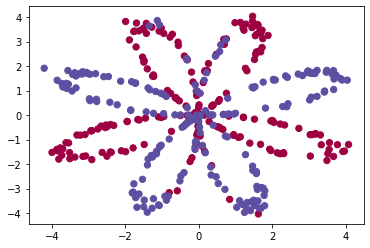

In [6]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

<a name='3'></a>
## 3 - Simple Logistic Regression

Before building a full neural network, let's check how logistic regression performs on this problem. You can use sklearn's built-in functions for this. Run the code below to train a logistic regression classifier on the dataset.

In [7]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T);

C:\Users\cxo87\Miniconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


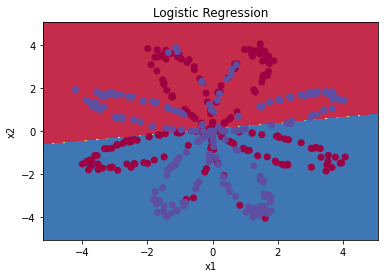

In [8]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print(
    "Accuracy of logistic regression: %d "
    % float(
        (np.dot(Y, LR_predictions) + np.dot(1 - Y, 1 - LR_predictions))
        / float(Y.size)
        * 100
    )
    + "% "
    + "(percentage of correctly labelled datapoints)"
)

In [9]:
model = LogitModel()
model.train(X, Y)

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


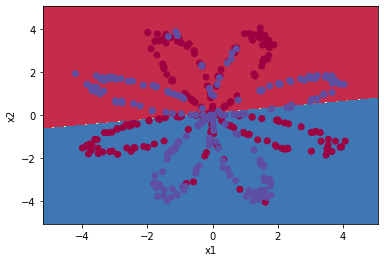

In [10]:
plot_decision_boundary(
    lambda x: LogitPredict().predict(model.params["w"], model.params["b"], x.T), X, Y
)
# Print accuracy
LR_predictions = LogitPredict().predict(model.params["w"], model.params["b"], X).T
print(
    "Accuracy of logistic regression: %d "
    % float(
        (np.dot(Y, LR_predictions) + np.dot(1 - Y, 1 - LR_predictions))
        / float(Y.size)
        * 100
    )
    + "% "
    + "(percentage of correctly labelled datapoints)"
)

<a name='4'></a>
## 4 - Neural Network model

Logistic regression didn't work well on the flower dataset. Next, you're going to train a Neural Network with a single hidden layer and see how that handles the same problem.

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

In practice, you'll often build helper functions to compute steps 1-3, then merge them into one function called `nn_model()`. Once you've built `nn_model()` and learned the right parameters, you can make predictions on new data.

<a name='5'></a>
### 5 - Test the Model on the Planar Dataset

It's time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units!

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220619
Cost after iteration 8000: 0.219398
Cost after iteration 9000: 0.218482


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

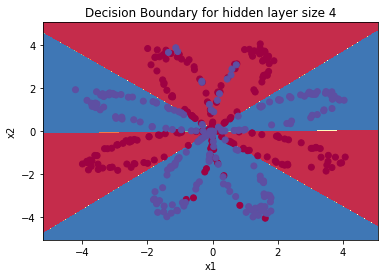

In [11]:
# Build a model with a n_h-dimensional hidden layer
nnmodel = NNModel()
nnmodel.train(X, Y, n_h=4, num_iterations=10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: nnmodel.predict(x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [12]:
# Print accuracy
predictions = nnmodel.predict(X)
print(
    "Accuracy: %d"
    % float(
        (np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T))
        / float(Y.size)
        * 100
    )
    + "%"
)

Accuracy: 90%


<a name='6'></a>
## 6 - Tuning hidden layer size

Run the following code(it may take 1-2 minutes). Then, observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 91.0 %
Accuracy for 50 hidden units: 90.25 %


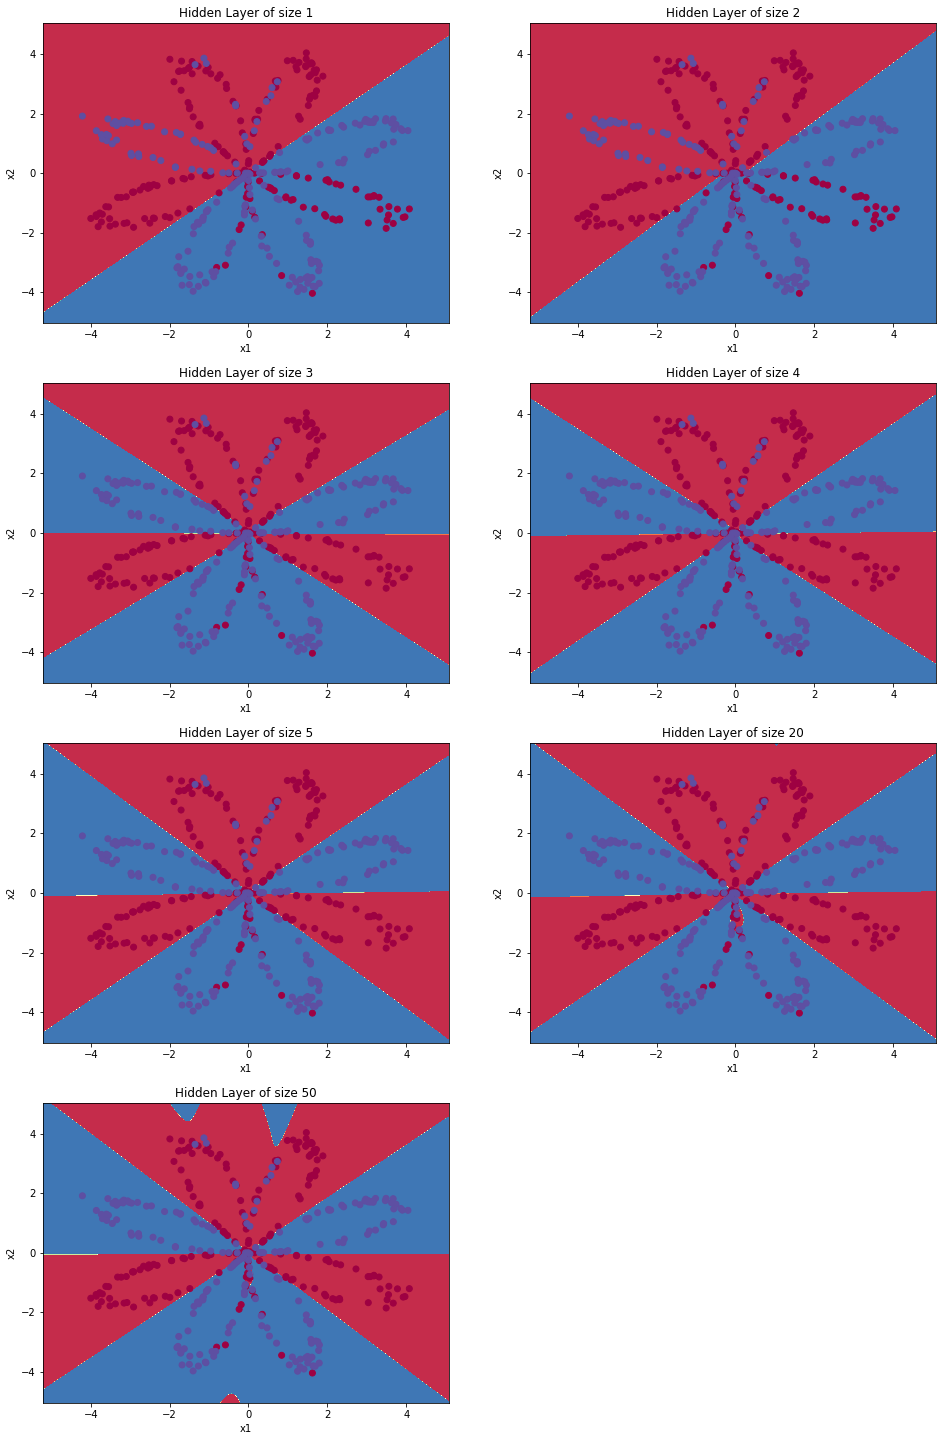

In [13]:
# This may take about 2 minutes to run
def tunning(X, Y, hidden_layer_sizes=[1, 2, 3, 4, 5, 20, 50]):
    plt.figure(figsize=(16, 32))
    for i, n_h in enumerate(hidden_layer_sizes):
        plt.subplot(5, 2, i + 1)
        plt.title("Hidden Layer of size %d" % n_h)
        nnmodel = NNModel()
        nnmodel.train(X, Y, n_h, num_iterations=5000)
        plot_decision_boundary(lambda x: nnmodel.predict(x.T), X, Y)
        predictions = nnmodel.predict(X)
        accuracy = float(
            (np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T))
            / float(Y.size)
            * 100
        )
        print("Accuracy for {} hidden units: {} %".format(n_h, accuracy))


tunning(X, Y)

<a name='7'></a>
## 7- Performance on other datasets

In [14]:
def choose_df(dataset="noisy_moons"):
    # Datasets
    (
        noisy_circles,
        noisy_moons,
        blobs,
        gaussian_quantiles,
        no_structure,
    ) = load_extra_datasets()

    datasets = {
        "noisy_circles": noisy_circles,
        "noisy_moons": noisy_moons,
        "blobs": blobs,
        "gaussian_quantiles": gaussian_quantiles,
    }

    X, Y = datasets[dataset]
    X, Y = X.T, Y.reshape(1, Y.shape[0])

    # make blobs binary
    if dataset == "blobs":
        Y = Y % 2

    # Visualize the data
    plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)

    return X, Y

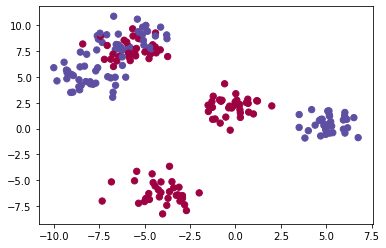

In [15]:
X, Y = choose_df(dataset="blobs")

Accuracy for 1 hidden units: 67.0 %
Accuracy for 2 hidden units: 67.0 %
Accuracy for 3 hidden units: 83.0 %
Accuracy for 4 hidden units: 83.0 %
Accuracy for 5 hidden units: 82.5 %
Accuracy for 20 hidden units: 88.0 %
Accuracy for 50 hidden units: 84.5 %


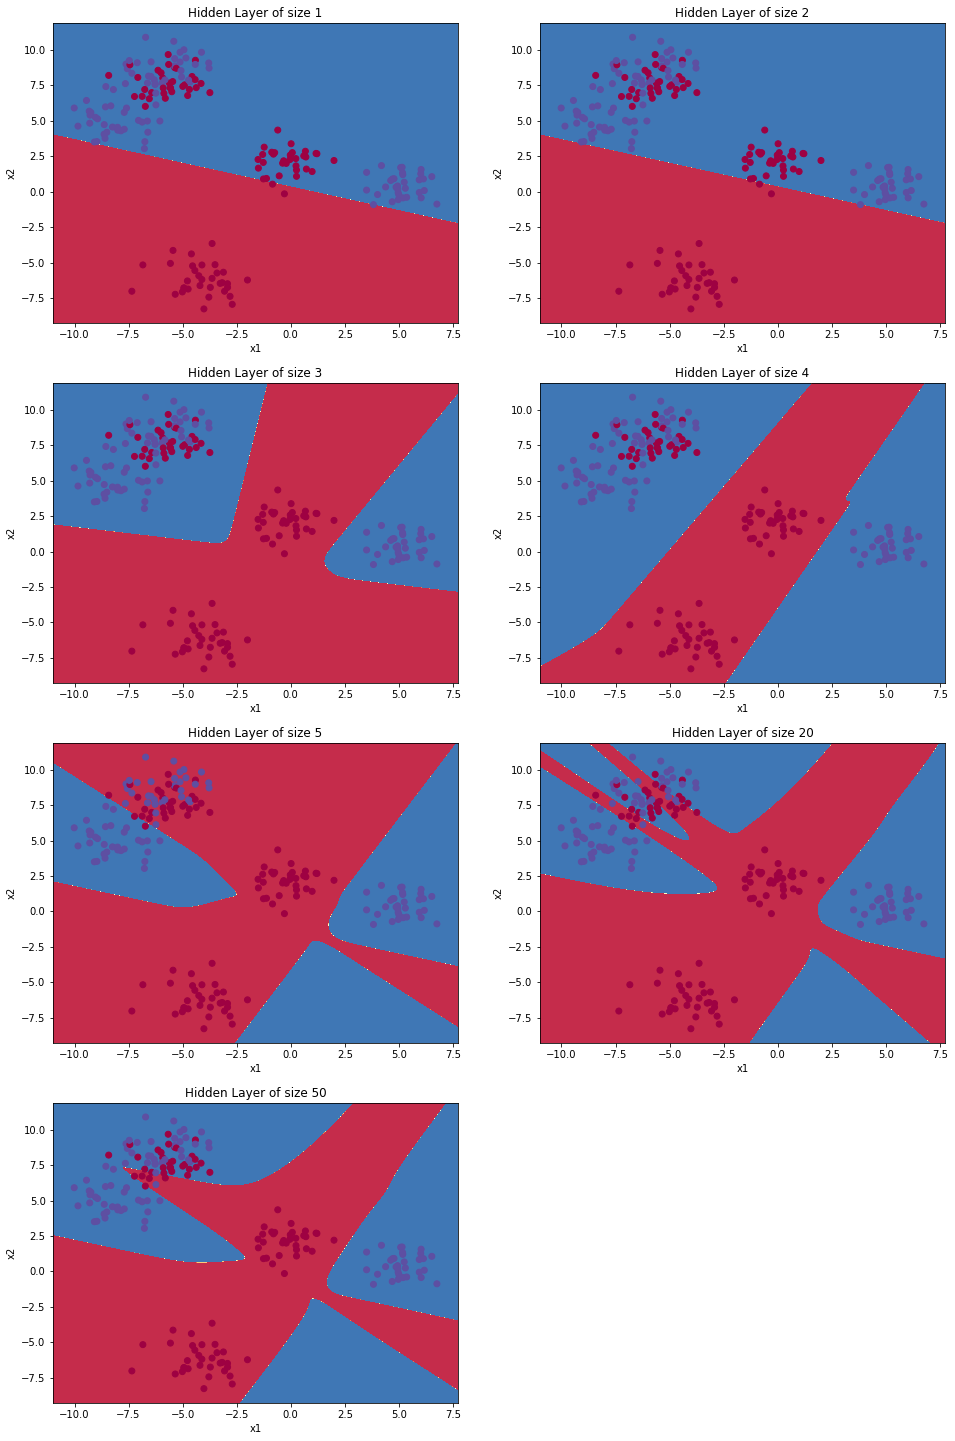

In [16]:
tunning(X, Y)